In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [2]:
class MnistDataset(Dataset):

  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass

  def __len__(self):
    return len(self.data_df)
  
  def __getitem__(self, index):
    # one-hot encoding
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    # range from 0 to 1
    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values) / 255.0

    return label, image_values, target
  
  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation='none', cmap='Blues')
    pass
  
  pass

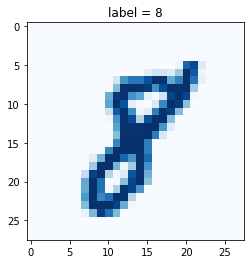

In [3]:
# load data
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

# check data contains images
mnist_dataset.plot_image(17)

In [11]:
# 판별기 만들기
class Discriminator(nn.Module):
  def __init__(self):
    # initialize pytorch class
    super().__init__()
    # definitiona of NN layer
    self.model = nn.Sequential(
        nn.Linear(784, 200),
        nn.Sigmoid(),
        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    # loss function
    self.loss_function = nn.MSELoss()

    # Optimiser
    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    # initialize variable for counting process
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # run model
    return self.model(inputs)
  
  def train(self, inputs, targets):
    # calculate NN outputs
    outputs = self.forward(inputs)

    # calculate loss
    loss = self.loss_function(outputs, targets)

    # increase counter and calculate error
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # initialize gradient and update w after back
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
  
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass

In [12]:
  # return noise pattern
  def generate_random(size):
    random_data = torch.rand(size)    # size == 4 -> 0과 1사이의 값을 가지는 텐서 4개를 반환함
    return random_data

In [14]:
D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  # real data
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # generated data
  D.train(generate_random(784), torch.FloatTensor([0.0]))
  
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


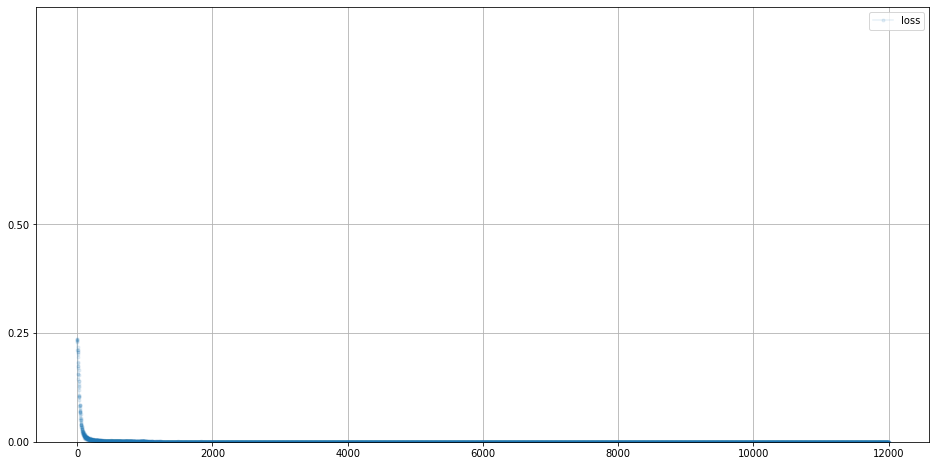

In [16]:
# plot discriminator loss
D.plot_progress()

In [21]:
# manually run discriminator to check it can tell real data from fake
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random(784)).item())
  pass

0.9803367257118225
0.9870691299438477
0.99562007188797
0.9960772395133972
0.006097085773944855
0.005556913558393717
0.006935310550034046
0.0048231277614831924


In [22]:
# 판별기 만들기
class Generator(nn.Module):
  def __init__(self):
    # initialize pytorch class
    super().__init__()
    # definitiona of NN layer
    self.model = nn.Sequential(
        nn.Linear(1, 200),
        nn.Sigmoid(),
        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    # Optimiser
    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    # initialize variable for counting process
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # run model
    return self.model(inputs)

  def train(self, D, inputs, targets):
    # calculate NN outputs
    g_output = self.forward(inputs)
    
    # give outputs to discriminator
    d_output = D.forward(g_output)

    # calculate loss
    loss = D.loss_function(d_output, targets)

    # increase counter and store loss every 10 times
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    
    # initialize gradient and update w after backward
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    pass
  
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
    pass

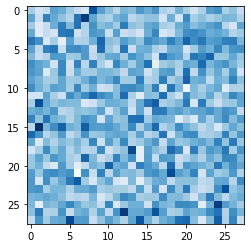

In [23]:
# check the generator output is of the right type and shape
G = Generator()
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28, 28)
plt.imshow(img, interpolation='none', cmap='Blues')

In [24]:
for label, image_data_tensor, target_tensor in mnist_dataset:
  # train discriminator for real data
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  # train discriminator for generated data
  # use deatch function not to calculate generator's gradient
  D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))

  # train Generator
  G.train(D, generate_random(1), torch.FloatTensor([1.0]))

  pass

counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000


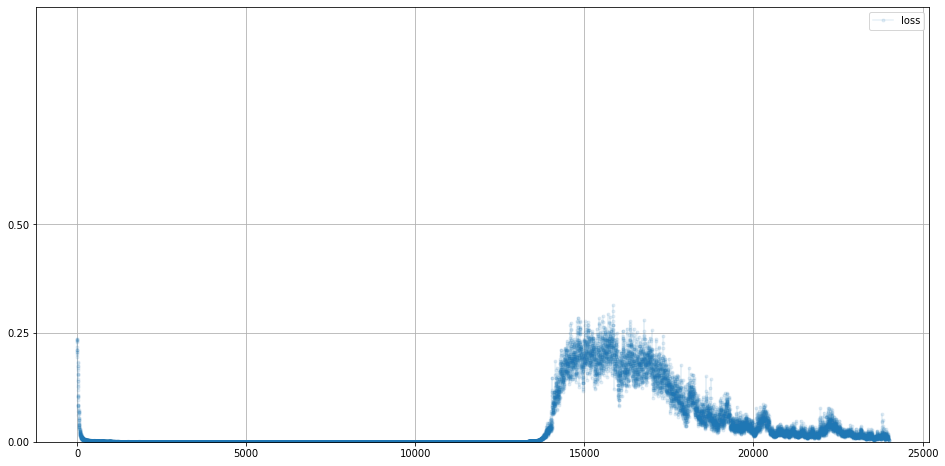

In [26]:
D.plot_progress()

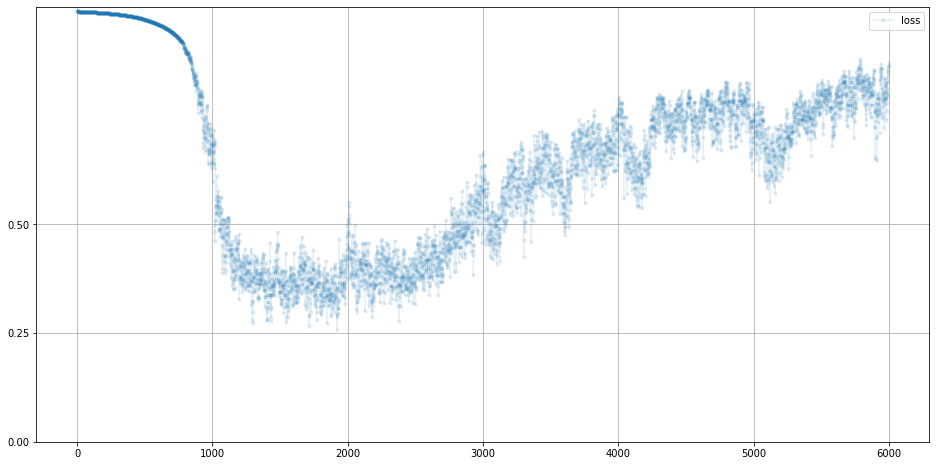

In [27]:
G.plot_progress()

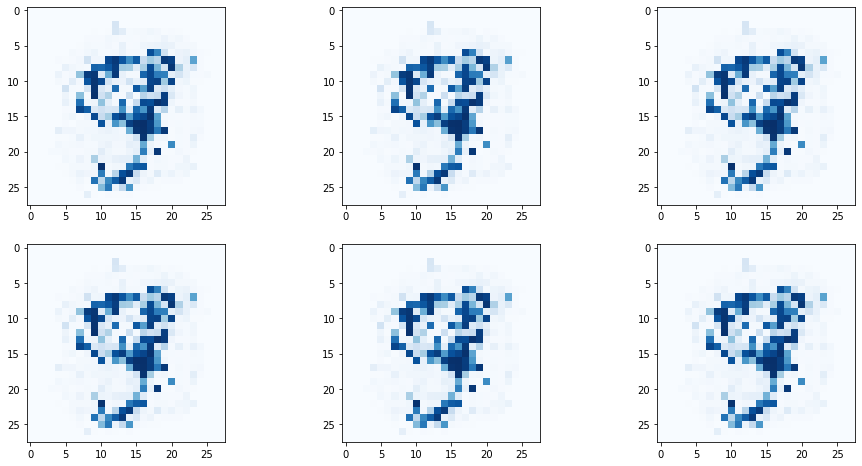

In [28]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2, 3, figsize=(16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(1))
    img = output.detach().numpy().reshape(28, 28)
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass